# Pairs Trading (Simplified)

Pairs trading is a strategy that uses two stocks that are highly correlated. We can then use the difference in price between the two stocks as signal if one moves out of correlation with the other. It is an older strategy that is used classically as a guide to beginning algorithmic trading.

See [more](http://www.investopedia.com/university/guide-pairs-trading/).

In [1]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 20

In [3]:
start = '2015-01-01'
end = '2017-01-01'

united = quandl.get('WIKI/UAL',start_date=start,end_date=end)
american = quandl.get('WIKI/AAL',start_date=start,end_date=end)

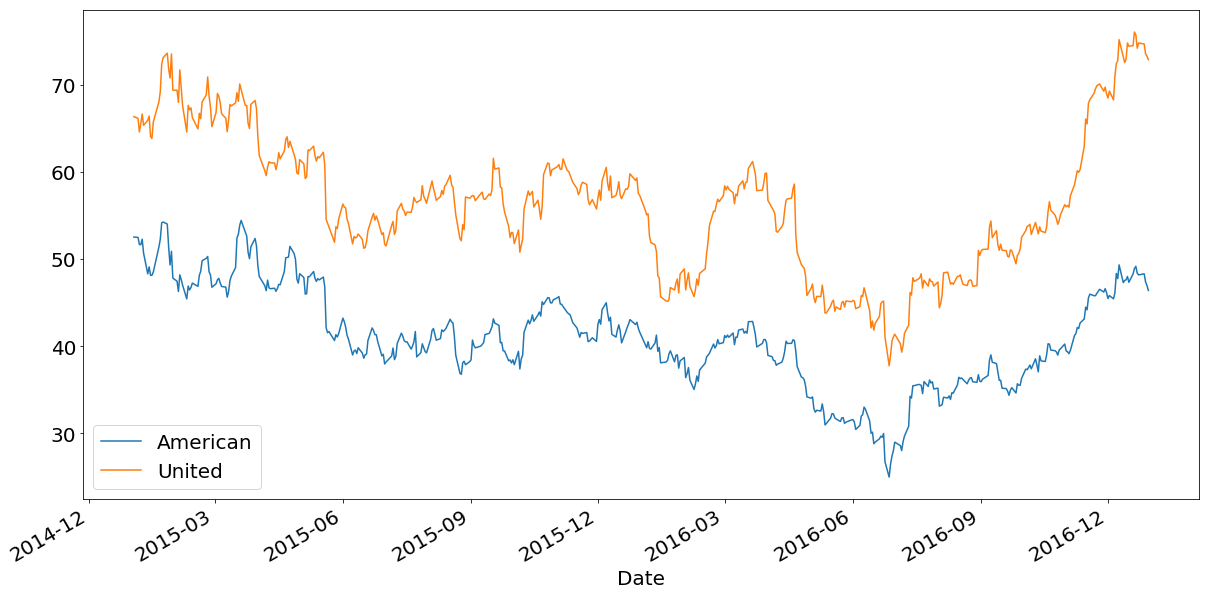

In [5]:
american['Adj. Close'].plot(
    figsize=(20, 10),
    label='American'
)

united['Adj. Close'].plot(label='United')

plt.legend();

## Correlation

In [6]:
pairs = pd.concat([
    american['Adj. Close'],
    united['Adj. Close']
], axis=1)

pairs.columns = ['American Adj. Close', 'United Adj. Close']

pairs.corr()

,American Adj. Close,United Adj. Close
American Adj. Close,1.000000,0.923352
United Adj. Close,0.923352,1.000000


## Spread 

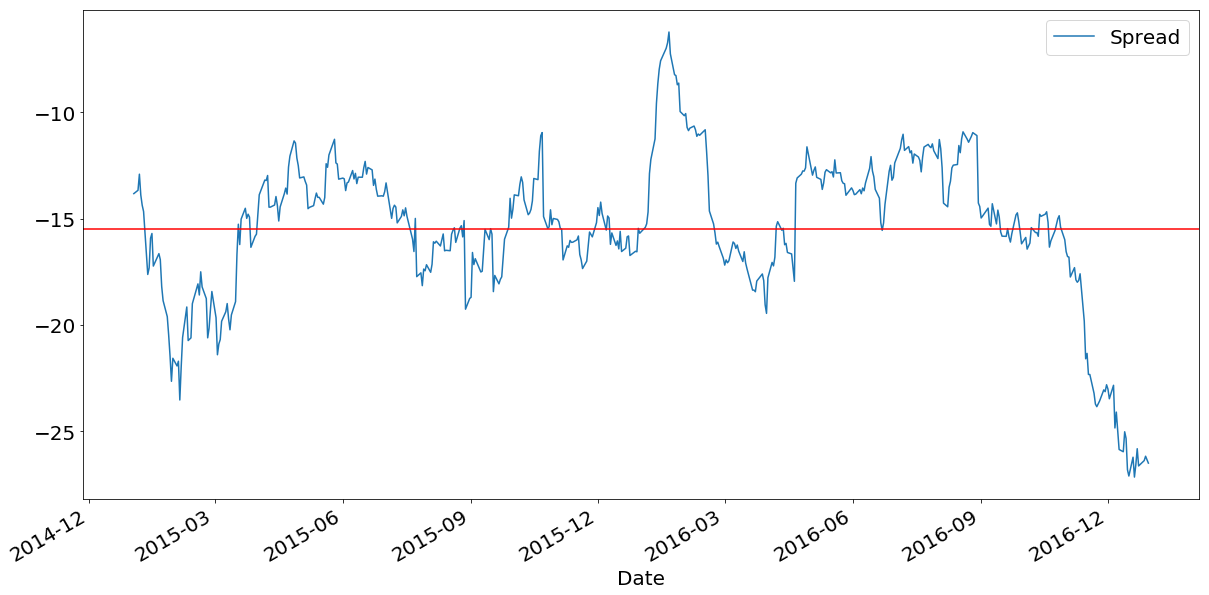

In [7]:
spread = american['Adj. Close'] - united['Adj. Close']

spread.plot(
    figsize=(20, 10),
    label='Spread'
)

plt.axhline(spread.mean(), c='r')

plt.legend();

## Normalisation using Z-Score

In [8]:
def z_score(stocks):
    return (stocks - np.mean(stocks)) / np.std(stocks)

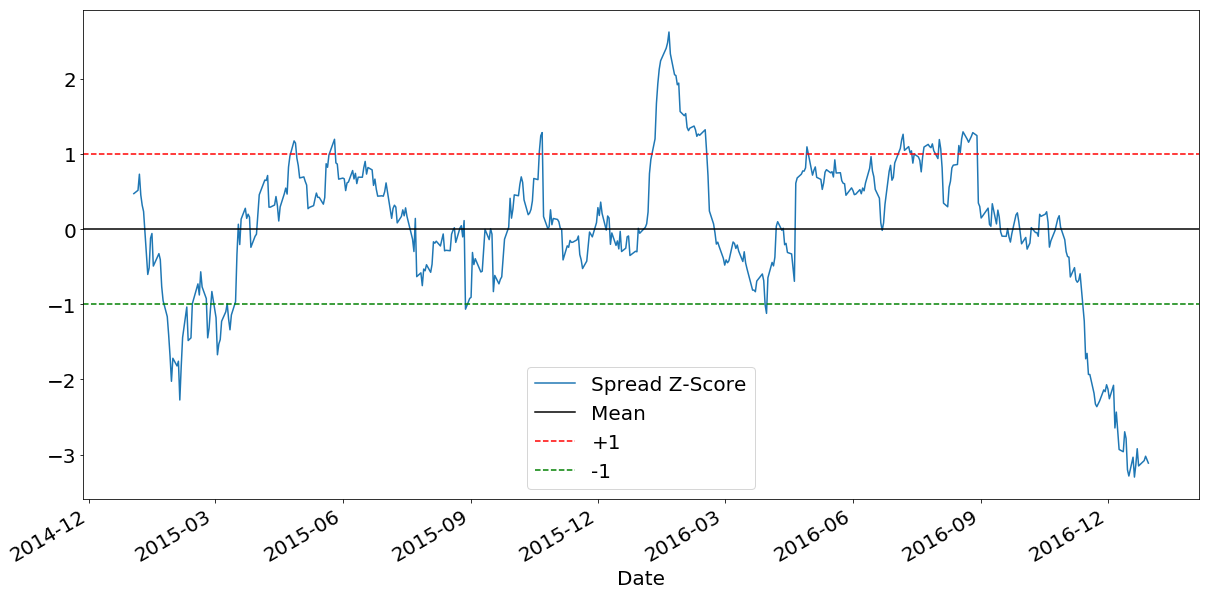

In [9]:
normalised = z_score(spread)
normalised.plot(figsize=(20, 10))

plt.axhline(normalised.mean(), color='black')
plt.axhline(1.0, c='r', ls='--')
plt.axhline(-1.0, c='g', ls='--')

plt.legend([
    'Spread Z-Score',
    'Mean',
    '+1',
    '-1'
]);

## Rolling Z-Score

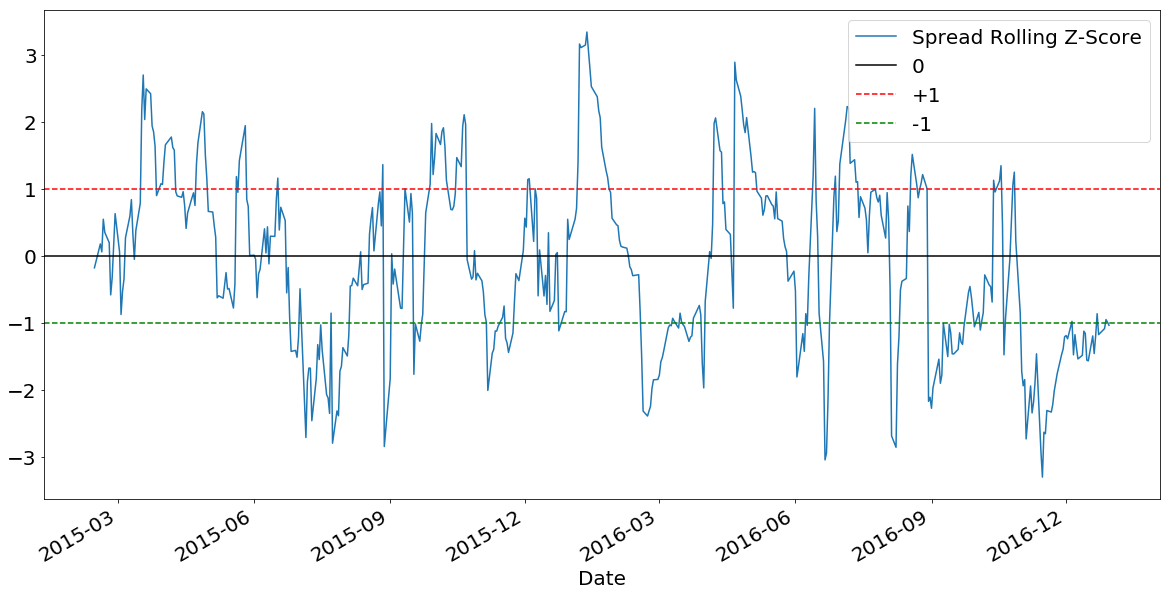

In [10]:
spread_1d_sma = spread.rolling(1).mean()
spread_30d_sma = spread.rolling(30).mean()
spread_30d_std = spread.rolling(30).std()

z_score_30_1 = (spread_1d_sma - spread_30d_sma) / spread_30d_std

z_score_30_1.plot(figsize=(20, 10))

plt.axhline(0, color='black')
plt.axhline(1.0, c='r', ls='--')
plt.axhline(-1.0, c='g', ls='--')

plt.legend([
    'Spread Rolling Z-Score',
    '0',
    '+1',
    '-1'
]);

## Trading Algorithm

(to be used on [Quantopian](https://www.quantopian.com/posts) platform)

In [ ]:
import numpy as np


def initialize(context):
    schedule_function(
        check_pairs,
        date_rules.every_day(),
        time_rules.market_close(minutes=60) # 1 hr before market closes
    )
    
    context.aa = sid(45971)
    context.ual = sid(28051)
    
    context.long_on_spread = False
    context.shorting_spread = False
    
    
def check_pairs(context, data):
    aa = context.aa
    ual = context.ual
    
    prices = data.history(
        [aa, ual],
        'price',
        30, # 30 days of price info
        '1d'
    )
    
    short_prices = prices.iloc[-1:]
    spread = prices[aa] - prices[ual]
    sma30 = np.mean(spread)
    std30 = np.std(spread)
    sma1 = np.mean(
        short_prices[aa] - short_prices[ual]
    )
    
    if std30 > 0:
        zscore = (sma1 - sma30) / std30
        
        if zscore > 0.5 and not context.shorting_spread:
            # SPREAD = AA - UAL
            # AA might be overvalued and regress to mean eventually
            order_target_percent(aa, -0.5) # short top
            order_target_percent(ual, 0.5) # long bottom
            context.shorting_spread = True
            context.long_on_spread = False
            
        elif zscore < -0.5 and not context.long_on_spread:
            # AA might undervalued
            order_target_percent(aa, 0.5) # long top
            order_target_percent(ual, -0.5) # short top
            context.shorting_spread = False
            context.long_on_spread = True
            
        # Exit positions
        elif abs(zscore) < 0.1:
            order_target_percent(aa, 0.0) # long top
            order_target_percent(ual, 0.0) # short top
            context.shorting_spread = False
            context.long_on_spread = False
            
        record('zscore', zscore)